####  iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋: iris.csv-> feature 3
- 구현 프레임워크: Pytorch


[1] 모듈 로딩 및 데이터 준비

In [159]:
# 모듈 로딩
import torch                    #텐서 및 수치 계산 모듈
import torch.nn as nn           #인공신경망
import torch.nn.functional as F      #손실, 거리 계산 모듈
import torch.optim as optimizer # 최적화 기법 모듈
import pandas as pd
from sklearn.model_selection import train_test_split


In [160]:
# 데이터 로딩
File='../data/iris.csv'
irisDF=pd.read_csv(File, usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
- 학습 방법: 지도학습(회귀)
- 알고리즘: 선형관계 >> 선형모델 ==>nn.linear

In [161]:
# in features: petal.length 3개
# out features: petal.width 1개
torch.manual_seed(1)

model=nn.Linear(3,1)
for name, param in model.named_parameters():
    print(name, param, '\n')

weight Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True) 

bias Parameter containing:
tensor([0.2710], requires_grad=True) 



[3] 최적화 인스턴스 준비


In [162]:
# 모델의 가중치와 절편을 최적화-> 인스턴스에 전달
adam_optim= optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습-> 개발자가 구현

[4-1] 데이터셋 Tensor화 진행: 데이터준비시 진행 or 학습 전 진행

In [163]:
# 데이터 프레임 컬럼=array -> .values=ndarray -> 대괄호 한번 더(shape)-> .from_numpy-> .float()
# ==>  n열, 1행짜리 tensor 생성
featureTS=torch.from_numpy(irisDF[['sepal.length', 'sepal.width', 'petal.length']].values).float()
featureTS.shape

torch.Size([150, 3])

In [164]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [165]:
X_train, X_test, Y_train, Y_test= train_test_split(featureTS,targetTS, test_size=.2)
X_train, X_val, Y_train, Y_val= train_test_split(X_train, Y_train, test_size=.2)

print(f'train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}')
print(f'train: {Y_train.shape}, val: {Y_val.shape}, test: {Y_test.shape}')

train: torch.Size([96, 3]), val: torch.Size([24, 3]), test: torch.Size([30, 3])
train: torch.Size([96, 1]), val: torch.Size([24, 1]), test: torch.Size([30, 1])


- [4-2] 학습 진행
    - 학습횟수 결정 ==> 에포크 설정
    - 학습결과 저장시 ==> 손실저장 변수 생성

In [166]:
# 테스트/검증 함수
# 가중치 업데이트X, 최적화 미진행
# 현재 가중치와 절편값으로 테스트 진행
def testing(model, X_test, Y_test, kind='Val'):
    with torch.no_grad():   #가중치 및 절편 업데이트 진행 X
        # (1) 학습진행  forward(순전파)
        # - 먼저 shape과 dtype이 동일한지 확인을 위해 실행해보기!!
        pre_y= model(X_test)

        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, Y_test)
        
        # (3) 최적화 - 가중치, 절편 업데이트 backward(역전파)
        # # - 가중치 초기화 -> 가중치 계산 -> 가중치 적용
        # adam_optim.zero_grad()
        # loss.backward()
        # adam_optim.step()
         
        # (5) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}')
        return loss

In [167]:
# 모델 학습 함수


def training(X_train, Y_train, X_test, Y_test):
    EPOCH=100
    loss_history=[[],[]]
    for epch in range(1,EPOCH+1):
        # (1) 학습진행  forward(순전파)
        # - 먼저 shape과 dtype이 동일한지 확인을 위해 실행해보기!!
        pre_y= model(X_train)

        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, Y_train)
        loss_history[0].append(loss.item())
        # (3) 최적화 - 가중치, 절편 업데이트 backward(역전파)
        # - 가중치 초기화 -> 가중치 계산 -> 가중치 적용
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4)검증
        val_loss=testing(model, X_test, Y_test)
        loss_history[1].append(val_loss.item())
        # (5) 학습결과 출력 및 저장
        print(f'[{epch}/{EPOCH}] LOSS: {loss}')
    return loss_history

In [168]:
loss_hist= training(X_train, Y_train, X_test, Y_test)

[Val] LOSS: 1.2167930603027344
[1/100] LOSS: 0.644173264503479
[Val] LOSS: 0.5261057615280151
[2/100] LOSS: 1.2437957525253296
[Val] LOSS: 0.350141316652298
[3/100] LOSS: 0.567986249923706
[Val] LOSS: 0.6265715956687927
[4/100] LOSS: 0.3910902738571167
[Val] LOSS: 0.5114017128944397
[5/100] LOSS: 0.6565454602241516
[Val] LOSS: 0.2254083752632141
[6/100] LOSS: 0.544243574142456
[Val] LOSS: 0.17280565202236176
[7/100] LOSS: 0.26625263690948486
[Val] LOSS: 0.30294135212898254
[8/100] LOSS: 0.21365036070346832
[Val] LOSS: 0.3149819076061249
[9/100] LOSS: 0.3366713225841522
[Val] LOSS: 0.17758946120738983
[10/100] LOSS: 0.34379443526268005
[Val] LOSS: 0.08181893080472946
[11/100] LOSS: 0.2056582123041153
[Val] LOSS: 0.12452077865600586
[12/100] LOSS: 0.10832888633012772
[Val] LOSS: 0.19821713864803314
[13/100] LOSS: 0.14577068388462067
[Val] LOSS: 0.18019692599773407
[14/100] LOSS: 0.21315012872219086
[Val] LOSS: 0.10562393814325333
[15/100] LOSS: 0.19082467257976532
[Val] LOSS: 0.082423970

In [169]:
len(loss_hist[1]), len(loss_hist[0])

(100, 100)

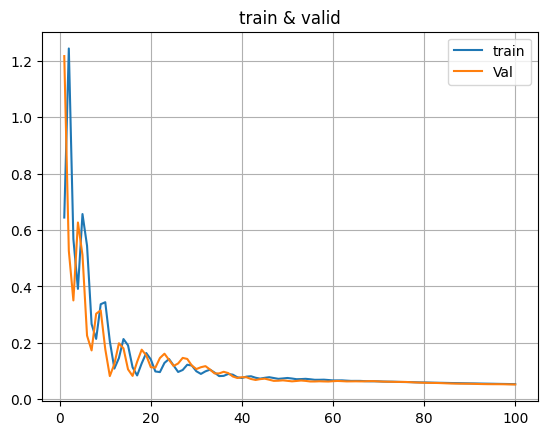

In [171]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(1,101), loss_hist[0], label='train')
plt.plot(range(1,101), loss_hist[1], label='Val')
plt.title('train & valid')
plt.grid()
plt.legend()
plt.show()